<font size = 10> **Mean depth and area per cell** </font>

# Loading relevant libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import geopandas
import UsefulFunctions as uf
from clef.code import *
import os
import cmocean as cm
%matplotlib inline

# Setting up paralellisation prior to analysis

In [2]:
client = Client(n_workers = 12)

# Using clef to check what data is available in ACCESS-ESM 1.5
Currently using conservative water temperature in historical experiment as an example 

In [3]:
#Creating a session and connecting to database
db = connect()
s = Session()

In [4]:
constraints = {'variable_id': 'areacello', 'model': 'ACCESS-ESM1-5', 'experiment_id':'historical', 'variant_label':'r1i1p1f1'}
area_path = search(s, project = 'CMIP6', latest = True, **constraints)

In [5]:
constraints = {'variable_id': 'thkcello', 'model': 'ACCESS-ESM1-5', 'experiment_id':'historical', 'variant_label':'r1i1p1f1'}
depth_path = search(s, project = 'CMIP6', latest = True, **constraints)

# Loading data

## Getting horizontal area of grid

In [6]:
filename = [f[0] for f in zip(area_path['filename'][0])]
filepath = os.path.join(area_path['path'][0], filename[0])

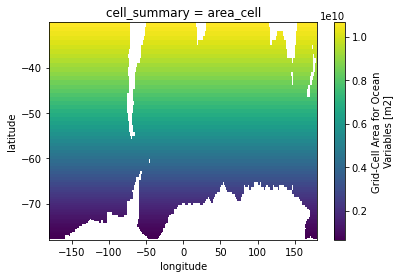

In [7]:
area = xr.open_dataarray(filepath, mask_and_scale = True, drop_variables = ("vertices_latitude", "vertices_longitude"))
#Correcting longitude prior to extracting Southern Ocean
area = uf.corrlong(area)
#Extracting Southern Ocean
area = area.sel(latitude = slice(-90, -30))
#Applying land mask
area = area.where(area!= 0)
area.name = 'area_cell'
area = area.expand_dims({'cell_summary': ['area_cell']})
#Checking data
area.plot()

## Getting thickness (vertical extent) of grid cells

In [8]:
filename = [f[0] for f in zip(depth_path['filename'][0])]
filepath = os.path.join(depth_path['path'][0], filename[0])

In [9]:
height = xr.open_dataset(filepath, mask_and_scale = True)
#Correcting longitude prior to extracting Southern Ocean
height = uf.corrlong(height)
#Extracting Southern Ocean
height = height.sel(latitude = slice(-90, -30))
height

<xarray.Dataset>
Dimensions:             (lev: 50, bnds: 2, latitude: 77, longitude: 360, vertices: 4)
Coordinates:
  * lev                 (lev) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * latitude            (latitude) float64 -77.88 -77.63 -77.38 ... -31.5 -30.5
  * longitude           (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (lev, bnds) float64 ...
    vertices_latitude   (latitude, longitude, vertices) float64 ...
    vertices_longitude  (latitude, longitude, vertices) float64 ...
    thkcello            (lev, latitude, longitude) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T14:47:31Z
    ...                     ...
    tracking_id:            hdl:21.14100/238d0fd0-40cd-40a6-8148-f56c12669260
    variable_id:            thkcello
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    license:                CMIP6 model data produced by CSIRO is licensed un...

### Calculating mean pixel height

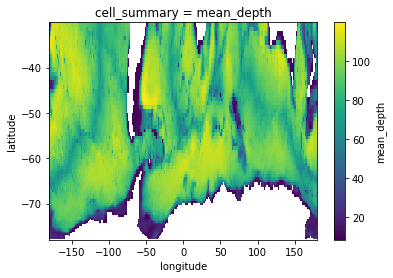

In [10]:
mean_height_pixel = height.thkcello.mean('lev')
mean_height_pixel.name = 'mean_depth'
mean_height_pixel = mean_height_pixel.expand_dims({'cell_summary': ['mean_depth']})
mean_height_pixel.plot()

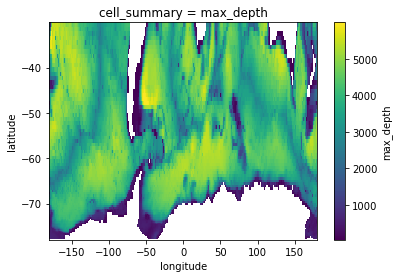

In [11]:
maxdepth = height.thkcello.sum('lev')
maxdepth = maxdepth.where(maxdepth != 0)
maxdepth.name = 'max_depth'
maxdepth = maxdepth.expand_dims({'cell_summary': ['max_depth']})
maxdepth.plot()

## Loading 2D mask

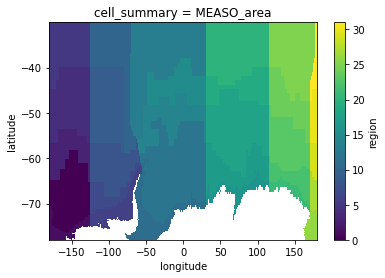

In [12]:
MEASO_mask = xr.open_dataarray('MEASO_2Dmask.nc')
MEASO_mask = MEASO_mask.expand_dims({'cell_summary': ['MEASO_area']})
MEASO_mask.plot()

# Merge all variables into one dataset

In [13]:
cell_summ = xr.concat([area, mean_height_pixel, maxdepth, MEASO_mask], dim = 'cell_summary')
cell_summ.to_netcdf('/g/data/v45/la6889/MEASO/MEASO_cell-summaries.nc')

In [14]:
cell_summ

<xarray.DataArray 'area_cell' (cell_summary: 4, latitude: 77, longitude: 360)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [6.55465600e+08, 6.55465600e+08, 6.55465600e+08, ...,
         6.55465600e+08, 6.55465600e+08, 6.55465600e+08],
        [6.71778496e+08, 6.71778496e+08, 6.71778496e+08, ...,
         6.71778496e+08, 6.71778496e+08, 6.71778496e+08],
        ...,
        [1.04077056e+10, 1.04077056e+10, 1.04077056e+10, ...,
         1.04077056e+10, 1.04077056e+10, 1.04077056e+10],
        [1.05348936e+10, 1.05348936e+10, 1.05348936e+10, ...,
         1.05348936e+10, 1.05348936e+10, 1.05348936e+10],
        [1.06526167e+10, 1.06526167e+10, 1.06526167e+10, ...,
         1.06526167e+10, 1.06526167e+10, 1.06526167e+10]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [2.33285217e+01, 2.28135700e+01, 2.20862217e+01, ...,
         2.20879955e+01, 2.39400082e+01, 2.36797237e+01],
        [2.22830963e+01, 2.24070854e+01, 2.20860386e+01, ...,
         2.20874119e+01, 2.22834988e+01, 2.29300938e+01],
...
        [2.69548242e+03, 4.16266504e+03, 5.99754590e+03, ...,
         3.27984204e+03, 2.42641919e+03, 2.69550781e+03],
        [2.08142847e+03, 2.07986572e+03, 5.44017236e+03, ...,
         3.69391138e+03, 3.09337402e+03, 2.08144653e+03],
        [2.04795410e+03, 5.12954773e+02, 4.42862891e+03, ...,
         3.91279785e+03, 3.11263013e+03, 2.05705615e+03]],

       [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         2.60000000e+01, 2.60000000e+01, 2.60000000e+01],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         2.60000000e+01, 2.60000000e+01, 2.60000000e+01],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         2.60000000e+01, 2.60000000e+01, 2.60000000e+01],
        ...,
        [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
         3.10000000e+01, 3.10000000e+01, 3.10000000e+01],
        [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
         3.10000000e+01, 3.10000000e+01, 3.10000000e+01],
        [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
         3.10000000e+01, 3.10000000e+01, 3.10000000e+01]]])
Coordinates:
  * cell_summary  (cell_summary) <U10 'area_cell' 'mean_depth' ... 'MEASO_area'
  * latitude      (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude     (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        Horizontal area of ocean grid cells
    units:          m2
    cell_methods:   area: sum